In [27]:
#!pip install susi

In [86]:
#!pip install minisom

  Created wheel for minisom: filename=MiniSom-2.3.0-py3-none-any.whl size=9018 sha256=ef27dd3df5e8498fd8f0e5a0ee83d49f486090ca35e1ee07e1adb1f4634893bb
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\7e\47\6d\97ad48be13d8b0fc231b7df226a3d6645820c32559822a826c
Successfully built minisom


In [152]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import susi
from minisom import MiniSom 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

In [259]:
df = pd.read_csv("voice.csv")

In [260]:
df.head()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402905,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male


In [261]:
df.shape

(3168, 21)

In [262]:
x = df.iloc[:, :-1]
y = df.iloc[:,-1]

In [263]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.3, random_state = 42)

In [19]:
est_range = range(100, 200, 10)
scores = []
for est in est_range:
    som = susi.SOMClassifier(n_rows = est,n_columns = est, random_state = 42, n_jobs = -1)
    som.fit(x_train, y_train)
    y_pred = som.predict(x_test)
    scores.append(metrics.accuracy_score(y_test, y_pred))

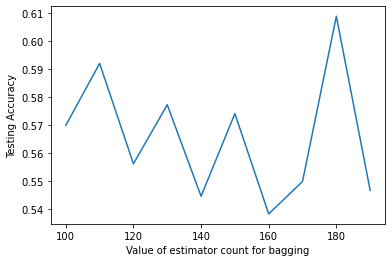

In [20]:
plt.plot(est_range, scores)
plt.xlabel('Value of estimator count for bagging')
plt.ylabel('Testing Accuracy')
plt.show()

In [21]:
est_range = range(200, 250, 10)
scores = []
for est in est_range:
    som = susi.SOMClassifier(n_rows = est,n_columns = est, random_state = 42, n_jobs = -1)
    som.fit(x_train, y_train)
    y_pred = som.predict(x_test)
    scores.append(metrics.accuracy_score(y_test, y_pred))

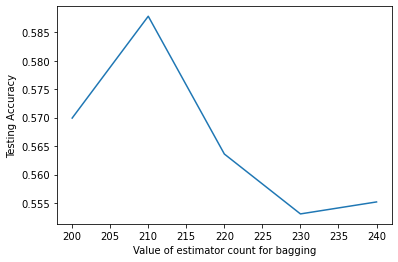

In [22]:
plt.plot(est_range, scores)
plt.xlabel('Value of estimator count for bagging')
plt.ylabel('Testing Accuracy')
plt.show()

### 180 is the best parameter for rows and columns (do not restart and run all cells, the optimization cells took hours to run)

### Variant 1. No Feature Selection

In [264]:
try:
    som_one = pickle.load(open("som_model_one.pickle", "rb"))
except (OSError, IOError) as e:
    som_one = susi.SOMClassifier(n_rows = 180,n_columns = 180, random_state = 42, n_jobs = -1)
    som_one.fit(x_train, y_train)
    with open('som_model_one.pickle','wb') as fe_data_file:
        pickle.dump(som, fe_data_file)

In [265]:
with open('som_model_one.pickle','rb') as fe_data_file:
     som_one = pickle.load(fe_data_file)
        
y_pred_one = som_one.predict(x_test)
print(metrics.accuracy_score(y_test,y_pred_one))

0.6088328075709779


## Feature Selection

In [266]:
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [267]:
correlated_features = correlation(x_train, 0.7)
print(correlated_features)
len(set(correlated_features))

{'sp.ent', 'Q25', 'IQR', 'Q75', 'dfrange', 'sd', 'maxdom', 'median', 'sfm', 'kurt', 'centroid'}


11

In [268]:
x.drop(labels = correlated_features, axis = 1, inplace = True)

In [269]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.3, random_state = 42)

### Variant 2. Feature Selection, less optimized hyperparameters

In [270]:
try:
    som_two = pickle.load(open("som_model_two.pickle", "rb"))
except (OSError, IOError) as e:
    som_two = susi.SOMClassifier(n_rows = 180,n_columns = 180,random_state = 42, n_jobs = -1)
    som_two.fit(x_train, y_train)
    with open('som_model_two.pickle','wb') as fe_data_file:
        pickle.dump(som_two, fe_data_file)
        y_pred_two = som_two.predict(x_test)

In [271]:
print(metrics.accuracy_score(y_test,y_pred_two))

0.5709779179810726


### Variant 3. No Feature Selection, more optimized hyperparameters

In [272]:
x = df.iloc[:, :-1]
y = df.iloc[:,-1]

In [273]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.3, random_state = 42)

In [ ]:
max_iter_range = range(10000, 30000, 5000)
scores = []
for est in max_iter_range:
    som = susi.SOMClassifier(n_rows = 180,n_columns = 180,n_iter_supervised= est,random_state = 42, n_jobs = -1)
    som.fit(x_train, y_train)
    y_pred = som.predict(x_test)
    scores.append(metrics.accuracy_score(y_test, y_pred))

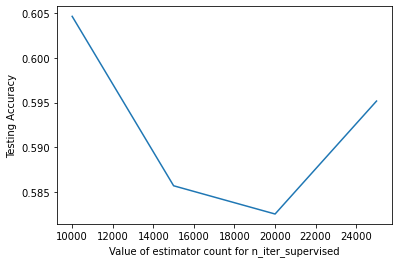

In [85]:
plt.plot(max_iter_range, scores)
plt.xlabel('Value of estimator count for n_iter_supervised')
plt.ylabel('Testing Accuracy')
plt.show()

### best iteration count is at 10000

In [275]:
try:
    som_three = pickle.load(open("som_model_three.pickle", "rb"))
except (OSError, IOError) as e:
    som_three = susi.SOMClassifier(n_rows = 180,n_columns = 180,n_iter_supervised= 10000,random_state = 42, n_jobs = -1)
    som_three.fit(x_train, y_train)
    with open('som_model_three.pickle','wb') as fe_data_file:
        pickle.dump(som_three, fe_data_file)
        y_pred_three = som_three.predict(x_test)

In [276]:
print(metrics.accuracy_score(y_test,y_pred_three))

0.6046267087276551


### Variant 4. Feature Selection + More optimized hyperparameters

In [277]:
x.drop(labels = correlated_features, axis = 1, inplace = True)

In [278]:
try:
    som_four = pickle.load(open("som_model_four.pickle", "rb"))
except (OSError, IOError) as e:
    som_four = susi.SOMClassifier(n_rows = 180,n_columns = 180,n_iter_supervised= 10000,random_state = 42, n_jobs = -1)
    som_four.fit(x_train, y_train)
    with open('som_model_four.pickle','wb') as fe_data_file:
        pickle.dump(som_four, fe_data_file)
        y_pred_four = som_four.predict(x_test)

In [279]:
print(metrics.accuracy_score(y_test,y_pred_four))

0.6046267087276551


### Variant 5: Standard Scaling without Feature Selection (with most optimized hyperparameters)

In [280]:
x = df.iloc[:, :-1]
y = df.iloc[:,-1]

In [281]:
scaler = StandardScaler()
scaler.fit(x)
x_std_pre = scaler.transform(x)

In [282]:
x_train,x_test,y_train,y_test = train_test_split(x_std_pre,y,test_size = 0.3, random_state = 42)

In [283]:
try:
    som_five = pickle.load(open("som_model_five.pickle", "rb"))
except (OSError, IOError) as e:
    som_five = susi.SOMClassifier(n_rows = 180,n_columns = 180,n_iter_supervised= 10000,random_state = 42, n_jobs = -1)
    som_five.fit(x_train, y_train)
    with open('som_model_five.pickle','wb') as fe_data_file:
        pickle.dump(som_five, fe_data_file)
        y_pred_five = som_five.predict(x_test)

In [284]:
print(metrics.accuracy_score(y_test,y_pred_five))

0.6046267087276551


### Variant 6: Standard Scaling with Feature Selection (with most optimized hyperparameters)

In [285]:
x.drop(labels = correlated_features, axis = 1, inplace = True)

In [286]:
scaler = StandardScaler()
scaler.fit(x)
x_std_post = scaler.transform(x)

In [287]:
x_train,x_test,y_train,y_test = train_test_split(x_std_post,y,test_size = 0.3, random_state = 42)

In [288]:
try:
    som_six = pickle.load(open("som_model_six.pickle", "rb"))
except (OSError, IOError) as e:
    som_six = susi.SOMClassifier(n_rows = 180,n_columns = 180,n_iter_supervised= 10000,random_state = 42, n_jobs = -1)
    som_six.fit(x_train, y_train)
    with open('som_model_six.pickle','wb') as fe_data_file:
        pickle.dump(som_six, fe_data_file)
        y_pred_six = som_six.predict(x_test)

In [289]:
print(metrics.accuracy_score(y_test,y_pred_six))

0.8538380651945321


In [290]:
print(metrics.classification_report(y_test,y_pred_six))

              precision    recall  f1-score   support

      female       0.84      0.85      0.85       452
        male       0.86      0.86      0.86       499

    accuracy                           0.85       951
   macro avg       0.85      0.85      0.85       951
weighted avg       0.85      0.85      0.85       951



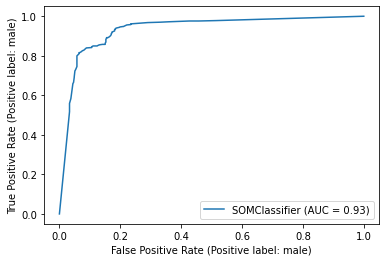

In [291]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_estimator(som_six, x_test, y_test)
plt.show()

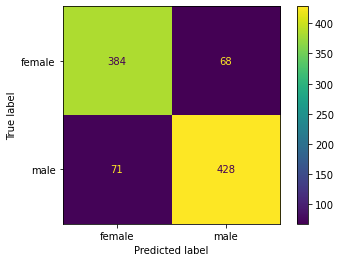

In [292]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(som_six, x_test, y_test)

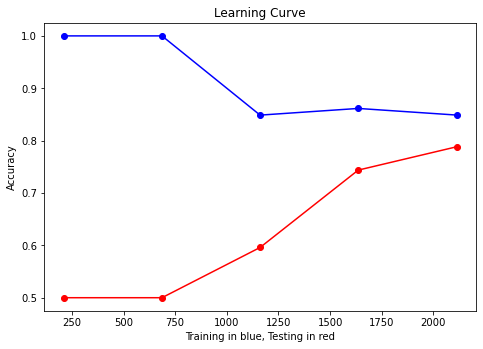

In [169]:
from sklearn.model_selection import learning_curve

train_sizes_model, train_scores_model, valid_scores_model, *_ =learning_curve(som_six, x_std_post, y,cv=3,
                    scoring='accuracy',n_jobs=-1)
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(x=train_sizes_model,y= train_scores_model.mean(axis=1), color='b')
ax.scatter(x=train_sizes_model,y=valid_scores_model.mean(axis=1), color='r')
ax.plot(train_sizes_model,train_scores_model.mean(axis=1), color='b')
ax.plot(train_sizes_model,valid_scores_model.mean(axis=1), color='r')
ax.set_xlabel('Training in blue, Testing in red')
ax.set_ylabel('Accuracy')
ax.set_title('Learning Curve')
plt.show()

In [302]:
y_train = y_train.replace(to_replace=['male', 'female'], value=[0, 1])

In [303]:
y_test = y_test.replace(to_replace=['male', 'female'], value=[0, 1])

In [296]:
def turnto(y_train, y_test):
    y_train=y_train.to_numpy()
    y_test=y_test.to_numpy()
    return y_train, y_test

#### Variant 1 (SOM + 2 Optimized Hyperparameters): 60.8%

#### Variant 2 (SOM + FS + 2 Optimized Hyperparameters): 57.09%

#### Variant 3 (SOM + 3 Optimized Hyperparameters): 60.4%

#### Variant 4 (SOM + FS + 3 Optimized Hyperparameters): 60.4%

#### Variant 5 (SOM + Std. Scaling + 3 Optimized Hyperparameters): 60.4%

#### Variant 6 (SOM + Std. Scaling + FS + 3 Optimized Hyperparameters): 85.3%

In [297]:
##### from mlxtend.evaluate import bias_variance_decomp
#turning pandas df and pandas series into numpy arrays
y_train_new,y_test_new = turnto(y_train,y_test)
print(type(y_train_new))
print(type(y_test_new))
#bias/variance
mse, bias, var = bias_variance_decomp\
(som_six, x_train, y_train_new, x_test, y_test_new, loss='mse', num_rounds=5, random_seed=42)

#values

print('MSE: %.3f' % mse)
print('Bias: %.3f' % bias)
print('Variance: %.3f' % var)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
MSE: 0.162
Bias: 0.078
Variance: 0.084
